# Exact emulator for Two-Body Bound State


This notebook contains the implementation of our exact emulator for two-body bound states for a toy-model example.
The goal is to find the eigenvector (wavefunction) of the Hamiltonian corresponding to a fixed binding energy $E_\text{B}$ for any allowed set of parameters $c_1$, $c_2$, $c_3$ which enter the potential. The values of the parameters are constrained by a condition that $E_\text{B}$ is the eigenvalue of the Hamiltonian. We find the explicit form of this condition as a part of building the emulator.

To enable exact and low-cost emulation of eigenvector problem, three prerequisites must be fulfilled:

<ul>

<li>

Emulated eigenvector corresponds to a fixed binding energy $E_\text{B}$ (only those parameters $c_1$, $c_2$, $c_3$ are allowed, which yield $E_\text{B}$ as an eigenvalue of the Hamiltonian)
</li>

<li>

Potential has the affine form (i.e. $V(p',p)=V_0(p',p)+c_1V_1(p',p)+c_2V_2(p',p)+c_3V_3(p',p)$)
</li>

<li>

Parameter-dependent parts of potential ($V_1$,$V_2$,$V_3$) are low-rank. Parameter-independent part $V_0$ may have any rank.
</li>

</ul>

This notebook demonstrates, that our emulator is computationally efficient and emulates bound state wavefunctions with accuracy limited only by machine precision.

## Table of contents
<ul>
<li> Definition of toy-model Hamiltonian and potential</li>
<li> Numerical setup<ul>
<li> Definitions of constants and integration grids</li>
<li> How to compute the wavefunction numerically</li>
<li> Potential</li>
</ul></li>
<li> Direct numerical wavefunction and mean-square matter radius calculation for specific parameter values </li>
<li> Exact emulator for wave function (and comparison to direct solution) </li>
<li> Emulator for mean-square matter radius of the bound state (and comparison to direct solution) </li>
</ul>

## Definition of the toy-model Hamiltonian and potential

For the toy model of two-body (e.g. NN) scattering, we will consider spinless particles and only $S$-wave scattering. Most calculations are done in momentum space.

### Schrödinger equation
The Schrödinger equation (SE) establishes the relationship between the Hamiltonian and the wavefunction. Negative eigenvalues of the Hamiltonian correspond to binding energies of bound states it supports, with the associated eigenvectors representing the corresponding bound state wavefunctions.
We consider the Schrödinger equation in partial-wave basis:

$$
\begin{align*}
H\Psi &= E_\text{B}\Psi\\
\int_0^\infty \mathrm{d}k\, k^2 H (p,k)\Psi(k)&=E_\text{B}\Psi\\
\frac{p^2}{2m_{\text{red}}}\Psi(p)+\int_0^\infty \mathrm{d}k\, k^2  V (p,k)\Psi(k)&=E_\text{B}\Psi
\end{align*}
$$

where $H(p,k)$ is the Hamiltonian, $V(p,k)$ is the potential and $p$ is the relative momentum in the center-of-mass frame of the two-body bound state and $m_{\text{red}}$ is the reduced mass of the two-body system. $E_\text{B}$ is the binding energy of the bound state.

### Potential

The potential $V (p', p)$ for which we want to calculate wavefunctions is given by 
$$
\begin{align*}
V (p', p) &= \underbrace{-\frac{\alpha}{8 \pi^2 p' p} \ln \left( \frac{(p'+p)^2 + M^2}{(p'-p)^2 + M^2} \right)}_{V_0}\\
& + c_1\cdot \underbrace{e^{-(p'{}^2 + p^2)/\Lambda^2}}_{V_1} + c_2 \cdot \underbrace{(p'^2 + p^2)e^{-(p'{}^2 + p^2)/\Lambda^2}}_{V_2} + c_3 \cdot \underbrace{p'{}^2p^2 e^{-(p'{}^2 + p^2)/\Lambda^2}}_{V_3}
\end{align*}
$$

$V_0$ is a partial-wave decomposed Yukawa-potential, with mass $M$ of the exchange-particle and strength $\alpha$. $c_1$, $c_2$, $c_3$ are the parameters of the potential and $V_1$, $V_2$ and $V_3$ their corresponding low-rank potentials.

### Mean-square matter radius

The mean-square matter radius $r_\text{m}^2$ of the bound state is given by 

$$
r_\text{m}^2=\frac14\int_0^\infty dr |u(r)|^2 r^2
$$
where $\Psi(r)=u(r)/r$ is the wavefunction in coordinate space.

## Numerical setup

### Physical constants, binding energy and integration grids

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
import scipy
# import plotting utilities
from matplotlib.colors import LogNorm

In [2]:
# define units: 
# to enter dimensionful quantities in code, multiply with respective unit
# to extract dimensionful quantities from code, divide by respective unit
GeV            = 1
MeV            = GeV/1e3
hbarc          = 1
# hbarc=197.3MeVfm
fm             = hbarc/(197.3*MeV)

reduced_mass    = 470*MeV # neutron-proton reduced mass
mass_pion       = 138*MeV 
ga              = 1.29
Fpi             = 0.0924*GeV

In [3]:
# Eb is the fixed(!) binding energy. 
# We build an emulator for eigenvector corresponding to this fixed eigenvalue
Eb              = -2.22*MeV

### How to compute the wavefunction numerically

The Schrödinger equation in momentum space is an integral equation, which can be discretized and written as a matrix equation.
We would like to find $\Psi(p)$, which is determined by the Schrödinger equation:

$$
\frac{p^2}{2m_{\text{red}}}\Psi(p)+\int_0^\infty \mathrm{d}k\, k^2  V (p,k)\Psi(k)=E_\text{B}\Psi
$$

#### Discretization
Discretizing momentum space integration can be done by the replacement $\int \text{d}k f(k) \rightarrow \sum_i \Delta_i f(k_i)$, where $i=1,...,n$ and $n$ is the total number of grid points used.
Define the matrix $H_{ij}$ via
$$
H_{ij} = \delta_{ij}\frac{p_ip_j}{2m_{\text{red}}}+V_{ij}\Delta_jp_j^2, \quad V_{ij} = V(p_i,p_j).
$$
and the vector $\Psi_i$, which is the wavefunction on the momentum space grid:
$$
\Psi_i = \Psi(k_i)
$$
With this, we can rewrite the Schrödinger equation as:
$$
\sum_j H_{ij}\Psi_j=E_\text{B}\Psi_i
$$
That means the vector $\Psi_i$, which we want to compute, is an eigenvector of the matrix $H_{ij}$ to the eigenvalue $E_\text{B}$.

In general, the integral over momentum in the SE goes from $0$ to $\infty$, but for simplicity we take as the upper end of the integration range a large momentum $p_{\max}$.

In [4]:
def grid(a, b, n):
    """
    Returns n Gauss-Legendre mesh points p and weights w on [a, b].
    Input: lower limit of integration interval a,
           upper limit of integration interval b,
           number of mesh points n
    Output: mesh points p and mesh weights w
    """
    x, w = np.polynomial.legendre.leggauss(n)
    p = 0.5*(b-a)*x + 0.5*(b+a)
    w = 0.5*(b-a)*w
    return p, w

In [5]:
# momentum mesh used to discretize integrals
p_max               = 2*GeV # upper end of integration mesh (instead of infinity)
nof_p_points        = 100   # number of points in integration mesh
p_points, p_weights = grid(0, p_max, nof_p_points)

## Toy model potential

The toy model potential mimics the 2-nucleon interaction and consists of two parts: long-range (parameter-free) and short-range (parameter-dependent).

The parameter-free part of the interaction potential $V_0$ is a Yukawa-type potential.
Strength and mass are chosen to be similar to the one-pion-exchange.

For normalization conventions we follow the two-nucleon SMS potential (see arXiv:1711.08821).

In [6]:
pot_norm = 1/(2*np.pi)**3 # normalization convention of the SMS potential
def yukawa(p, pp):
    """
    Toy model Yukawa potential in momentum space projected onto S partial wave. 
    This part of potential is parameter free.
    Mass and prefactor are chosen to mimic one-pion-exchange.

    Input:  p (pp) absolute values of initial (final) relative momenta 
    Output: V0 two-body potential
    """   
    alpha  = ( mass_pion * ga / (2*Fpi) )**2
    result = -alpha*2*np.pi/(2*p*pp)*np.log(((p+pp)**2+mass_pion**2)\
                                           /((p-pp)**2+mass_pion**2))
    return pot_norm*result

### Parameter-dependent part of potential

We choose the parameter-dependent potential in a separable form. It is given by

$$ 
\mathrm{exp}(-p'^2/\Lambda^2)\left[ c_1+c_2\cdot(p'^2+p^2)+c_3\cdot p'^2 p^2 \right] \mathrm{exp}(-p^2/\Lambda^2)
$$

with the three parameters (LECs) $c_1$, $c_2$, $c_3$ and the fixed cutoff $\Lambda=500\,\text{MeV}$.

The main goal of emulator is to quickly produce the bound state wavefunction for any values of these parameters, which yield a Hamiltonian with eigenvalue equal to $E_\text{B}$.

On the discretized momentum mesh this potential is a matrix $V_{ij}$ with the following entries:

$$
V_{ij} = \mathrm{exp}(-p_i^2/\Lambda^2)\left[c_1+c_2\cdot(p_i^2+p_j^2)+c_3\cdot p_i^2 p_j^2 \right]\mathrm{exp}(-p_j^2/\Lambda^2) \\
$$

In [7]:
unit_c1 = 1e4/GeV**2 # Following the SMS convention for units of LECs (parameters)
unit_c2 = 1e4/GeV**4 # in this units LECs are expected to be 
unit_c3 = 1e4/GeV**6 # natural, i.e. roughly of size 1

# regulator function to regularize the potential updates
def regulator(p, Lambda=0.5*GeV):
    """
    Regulator function e^(-p^2/Lambda^2)
    Input:  absolute value of relative momenta (p)
            and cutoff Lambda 
    Output: e^(-p^2/Lambda^2)
    """
    return np.exp(-p**2/Lambda**2)


def potential123(p, pp, c1,c2,c3):
    """
    Gives the value for the potential c1*V1+c2*V2+c3*V3
    Input:  p (pp) absolute values of initial (final) relative momenta
            c1,c2,c3 parameters of potential [dimensionless!]
    Output: c1*V1+c2*V2+c3*V3 two-body potential
    """   
    V1 =              regulator(p)*regulator(pp)
    V2 = (p**2+pp**2)*regulator(p)*regulator(pp)
    V3 = p**2*pp**2  *regulator(p)*regulator(pp)

    return pot_norm*(c1*unit_c1*V1+c2*unit_c2*V2+c3*unit_c3*V3)

### Parameter-dependent part of the potential as a low-rank matrix

We can rewrite the parameter-dependent part of the potential as the product of three matrices:

$$
V_{ij} = [X\cdot C\cdot Z]_{ij}
$$

with the the $n \times 2$ matrix $X_{i1}=\mathrm{exp}(-p_i^2/\Lambda^2)$, $X_{i2}=\mathrm{exp}(-p_i^2/\Lambda^2)p_i^2$, 
the $2 \times 2$ matrix $C=[[c1,c2],[c2,c3]]$ and the $ 2 \times n$ matrix $Z=X^T$.

In such form, this potential is a matrix of rank 2.

In [8]:
# three parameters as sympy symbols
c1_symb, c2_symb, c3_symb = sympy.symbols(r'c_1 c_2 c_3')

# matrices which define the low-rank update to the
# parameter-free potential matrix
X          = np.sqrt(pot_norm)*\
             np.array([regulator(p_points),
                       p_points**2*regulator(p_points)]).T
Cmat_symb  = np.array([[c1_symb*unit_c1, c2_symb*unit_c2],
                       [c2_symb*unit_c2, c3_symb*unit_c3]])
Z          = X.T
# full potential is now given by V=V0+X@C@Z

In [9]:
# verify that both methods to calculate parameter-dependent
# potential yield the same values
trial_c1 = 1
trial_c2 = 2
trial_c3 = 3

# Calculate potential in the usual way
V123       = np.zeros((nof_p_points, nof_p_points))
for p_idx, p in enumerate(p_points):
    for pp_idx, pp in enumerate(p_points):
        V123[p_idx, pp_idx]=potential123(p=p, pp=pp,
                                         c1=trial_c1,
                                         c2=trial_c2,
                                         c3=trial_c3)

# Calculate potential using X@C@Z form
C  = np.array([[trial_c1*unit_c1, trial_c2*unit_c2],
               [trial_c2*unit_c2, trial_c3*unit_c3]])
V123_lr =X@C@Z

print(np.allclose(V123, V123_lr)) # both methods yield same matrix

True


## Direct numerical calculation of wavefunction and mean-square matter radius for specific parameter values

In [10]:
# pre-compute the parameter-free Yukawa potential
# for mesh points and store it in the matrix V0
V0 = np.zeros((nof_p_points, nof_p_points))
for p_idx, p in enumerate(p_points):
    for pp_idx, pp in enumerate(p_points):
        V0[p_idx, pp_idx]=yukawa(p=p, pp=pp)

In [11]:
def get_Hamil(c1, c2, c3,
              p_points=p_points,
              p_weights=p_weights,
              reduced_mass=reduced_mass):
    """
    Computes the matrix H_ij as the sum of kinetic
    part and potential discretized on the momentum
    mesh points p_points and multiplied with the
    integration measure (see above for definition of H_ij).

    Input:   c1,c2,c3  parameters of the potential
             p_points  momentum mesh points
             p_weights momentum mesh weights
             reduced_mass reduced mass of two-body system
    Output:  the matrix H_ij
    """
    # compute matrix C for given parameters
    Cmat = np.array([[c1*unit_c1, c2*unit_c2],
                     [c2*unit_c2, c3*unit_c3]])
    # compute full potential V
    V = V0 + X @ Cmat @ Z

    # now compute V_ij*Delta_j*p_j^2
    w = p_weights * p_points**2
    H = V * w
    # add the kinteic part
    kinetic = p_points**2 / (2 * reduced_mass)
    H[np.diag_indices(len(H))] += kinetic
    return H

Now we have a function (`get_Hamil`) computing the matrix, whose negative eigenvalues are the binding energies of supported bound states while their associated eigenvectors represent their wavefunctions.

In [12]:
def normalize_WF(wf):
    # normalize wf such that <Psi|Psi> = int dp p^2 <Psi|p><p|Psi> = 1 
    wf = wf/np.sqrt(np.sum((wf*p_points)**2*p_weights))
    # set sign of wf, such that wavefunction
    # is positive at large momentum 
    wf = np.sign(wf[-1])*wf
    return wf


def calc_eigenvector_precise(Hamiltonian, energy=Eb, inv_iterat=False,
                          eigvec_tol=np.finfo(float).eps):
    """    
    This function calculates the eigenvector of the matrix 'Hamiltonian'
    corresponding to the eigenvalue 'energy'. It does it a bit more accurately than
    standard eigenvalue solvers such as 'np.linalg.eig'.

    To push numerical accuracy to the limit of machine precision, 
    we avoid the use of standard eigenvalue solvers,
    which might become less precise when eigenvalues are close or matrices very large. 
    We want to find vector x, which minimizes the 2-norm H@x - energy*x.
    Numerically, this is found by doing a SVD of the Matrix H - energy*1 
    and picking the right singular vector which corresponds to smallest
    singular value. 

    Input: Hamiltonian (2d array), must have energy as eigenvalue
           energy,     eigenvalue of Hamiltonian
           inv_iterat, increases accuracy of eigenvector
           eigvec_tol, accuracy threshold

    Output: x, eigenvector of matrix Hamiltonian to eigenvalue 'energy'
    """
    # # Compute eigenvalues and eigenvectors of matrix Hamiltonian
    # eigv, eigvecs=np.linalg.eig(Hamiltonian)
    # # Find the index of the eigenvalue closest to energy
    # eigv_idx = np.argmin(abs(eigv-energy))
    # # return eigenvector of Hamiltonian of that eigenvalue 
    # # which is closest to energy.
    # return eigvecs[:,eigv_idx]
    
    # right singular vector to smallest eigenvalue 
    # gives that vector x which minimizes the 2-norm
    # of H@x-energy*x.
    M      = Hamiltonian-energy*np.eye(len(Hamiltonian))
    _,_,Vh = np.linalg.svd(M)
    x      = Vh[-1]

    if inv_iterat: # refine eigenvector if needed using inverse iteration
        for _ in range(10):
            x = np.linalg.solve(M,x)
            x = x/np.linalg.norm(x)
        if np.linalg.norm(M@x)>eigvec_tol:
            raise Exception('iterative refinement of eigenvector did'+
                             ' not succeed!, error:'\
                            +str(np.linalg.norm(M@x)))            
    return x

We only consider wavefunctions corresponding to the eigenenergy $E_\text{B}$.
The following function determines a value of the parameter $c_1$ for given $c_2$ and $c_3$, such that $\text{det}(H(c_1,c_2,c_3)-E_\text{B}𝟙)=0$, i.e. $E_\text{B}$ is an eigenvalue of $H(c1,c2,c3)$.

In [13]:
def c1_fixtoBE_via_det0(c2,c3,energy=Eb, xtol=np.finfo(float).eps):
    """
    This methods finds a value of c1 for given c2 and c3, such that
    the Hamiltonian will have 'energy' as an eigenvalue.
    Input:   c2, c3, energy
    Output:  c1
    """
    # If Hamiltonian should have energy as eigenvalue, 
    # then det(H(c1,c2,c3)-energy*unity) should become 0 
    # for the given parameters.

    def det_func(c1, c2, c3):
        # computes det (H(c1,c2,c3)-energy*unity)
        M = get_Hamil(c1, c2, c3) 
        M = M - energy * np.eye(nof_p_points)
        return scipy.linalg.det(M)
    
    # use root finding to determine where det_func becomes 0
    res = scipy.optimize.root_scalar(det_func,args=(c2, c3), x0=0,
                                     xtol=xtol, maxiter=50)
    if not res.converged:
        raise Exception('Determining c1, such that Hamiltonian'+
                        ' has eigenvalue equals to '\
                        +str(energy)+" did not converge!")
    return res.root

### Wavefunction
We can now calculate wavefunctions for the considered toy-model potential:

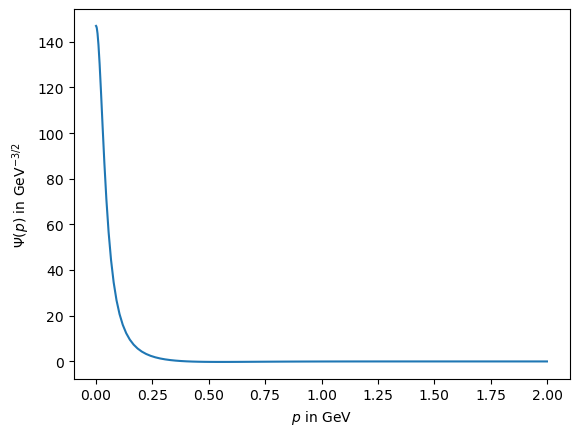

In [14]:
# compute wavefunction
test_c2 = 1
test_c3 = -1
test_c1 = c1_fixtoBE_via_det0(test_c2, test_c3)
H   = get_Hamil(test_c1, test_c2, test_c3)
Psi = calc_eigenvector_precise(H)
Psi = normalize_WF(Psi)
# plot wavefunction
plt.plot(p_points, Psi)
plt.xlabel(r'$p$ in GeV')
plt.ylabel(r'$\Psi(p)$ in GeV$^{-3/2}$')
plt.show()

In [15]:
# check, if Psi is and eigenvector to H to eigenvalue Eb
print(np.allclose(H@Psi, Eb*Psi)) 

True


### Mean-square matter Radius

Next, we want to compute the mean-square matter radius of this bound state. We can compute it using the formula:
$$
r_\text{m}^2=\frac14\int_0^\infty dr |u(r)|^2 r^2
$$
where $\Psi(r)=u(r)/r$ is the wavefunction in coordinate space. We need the wavefunction in coordinate space instead of momentum space. To get it we perform a Fourier transformation:
$$
u(r)=r\Psi(r)=i^l \sqrt{\frac{2}{\pi}}\,r\int_0^\infty \text{d}p\, p^2 \,\Psi_l(p)\, j_l(pr)
$$
where $l=0$ is the angular momentum of the wavefunction and $j_l(pr)$ is the spherical Bessel function. 
For integrals in coordinate space we introduce coordinate space grid:

In [16]:
# coordinate space grid
# goes from 0fm to 50fm with 1000 points
r_points, r_weights = grid(0*fm, 50*fm, 1000)

In [17]:
def FT_WF_to_coordinate(wf_momentum, momentum_grid, coordinate_grid):
    """
    Here we do a Fourier transformation of a given Wavefunction in
    momentum space to coordinate space.
    
    u_l (r) / r = i**(l) sqrt(2/pi) * 
                  integral_{from 0 to infinity} Psi_l (p) j_l(p*r)p**2 dp
    
    where Psi_l(p) is the wavefunction in momentum space with angular
    momentum l.
    j_l are the spherical Bessel functions.
    Because the Bessel functions oscillate heavily, we will increase
    the number of momentum points and interpolate Psi_l(p) to
    many more points.
    Psi_l(r) is given by u(r)/r

    Input: wf_momentum,     wavefunction in momentum space
           momentum_grid,   momentum grid points on which wf_momentum is given
           coordinate_grid, coordinate grid points at which returned 
                            wavefunction is computed
    
    Output: u(r) in coordinate space on the given coordinate_grid
    """
    l = 0 # we only consider S-waves 

    # Interpolate the momentum space wavefunction to 
    wf_mom_func = scipy.interpolate.CubicSpline(momentum_grid, wf_momentum)
    
    def integrand(p,r):
        # compute the integrand for given p and r
        j_l = scipy.special.spherical_jn(l, p*r) # spherical Bessel function
        return 1j**l*np.sqrt(2/np.pi)*wf_mom_func(p)*j_l*p**2
    
    wf_coordinate = np.zeros(len(coordinate_grid), dtype=np.complex128)
    for i,x in enumerate(coordinate_grid):
        # compute the Fourier transform integral via discretization
        int_result = scipy.integrate.fixed_quad(integrand,
                                                0, max(momentum_grid),
                                                args=[x], n=5000)
        # store the integration result
        wf_coordinate[i] = int_result[0] * x
    return np.real_if_close(wf_coordinate)

Now we can compute the radius $r_m$ using the discretized coordinate space wavefunction:

In [18]:
u_r = FT_WF_to_coordinate(Psi, momentum_grid   = p_points,
                                 coordinate_grid = r_points)
# calculate rms
rms_ordinary = 1/2*np.sqrt(np.sum(r_weights*r_points**2*u_r**2))
rms_ordinary/fm

1.9633972328753913

## Exact emulator for the wavefunction

### Calculation of snapshots

Next, we will find wavefunctions for several values of the parameters $c_2$ and $c_3$, while we fix $c_1$, such that the binding energy constraint is fulfilled.

Based these snapshots we will compute a basis consisting of just a few vectors, in which we can represent our eigenvector problem exactly.
To demonstrate performance of emulator, we will only consider a small number of snapshots in a small parameter region and then emulate solutions in large parameter space.

In [19]:
# Calculate snapshots within a small region 
# (here parameters c2 and c3 are taken to be [-0.1,0.1])
# and only small number of snapshots
# (here we take 4 snapshots, however 2 would be already sufficient,
# since rank of parameter-dependent potential is 2)

# values of c2 and c3 for each of 4 snapshots 
# value of c1 will be determined later
# by condition that we need to reproduce fixed binding energy
snapshot_values = np.array([[-.1,-.1],
                            [.1, -.1],
                            [-.1, .1],
                            [.1, .1]])

In [20]:
snapshot_wf = np.zeros((len(snapshot_values), nof_p_points))

for snap_idx, [c2, c3] in enumerate(snapshot_values):
    # First we find the value of c1, such that binding energy
    # constraint is fulfilled
    c1                    = c1_fixtoBE_via_det0(c2,c3)      
    # compute Hamiltonian for c1,c2,c3
    H                     = get_Hamil(c1, c2, c3)
    # compute wavefunction (eigenvector of Hamiltonian corresponding
    # to eigenvalue Eb)
    snapshot_wf[snap_idx] = calc_eigenvector_precise(H,inv_iterat=True)

In [21]:
# Perform SVD to find reduced basis and its dimension
U,S,Vh = np.linalg.svd(snapshot_wf)

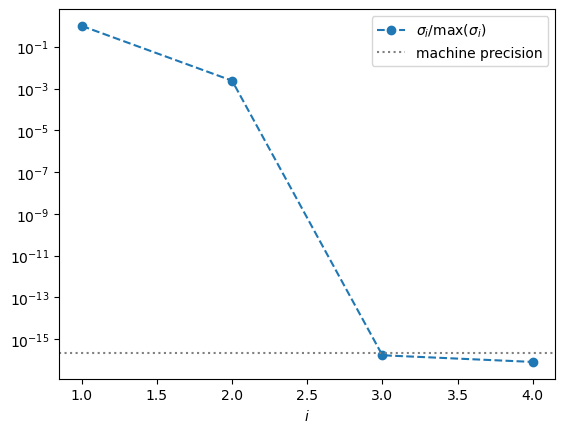

In [22]:
# plot the singular values
plt.plot(np.arange(1,len(S)+1), S/np.max(S), 'o', ls='--',
                  label=r'$\sigma_i/\mathrm{max}(\sigma_i)$')
plt.yscale('log')
plt.xlabel(r'$i$')
plt.axhline(np.finfo(float).eps, ls=':', color='grey',
            label='machine precision')
plt.legend()
plt.show()

As can be seen from the above plot, only 2 singular values are non-zero, up to machine precision. This demonstrates that the 4 snapshots lie in just a two-dimensional subspace. 

This result is fully in agreement with our expectations, that the wavefunction only varies in an $r$-dimensional subspace, where $r$ is the rank of the parameter-dependent part of potential. 

In the following, we will project the full Hamiltonian matrix onto a 2-dimensional basis, which is given by the 2 right singular vectors, corresponding to the 2 non-zero singular values.

### Projection of Hamiltonian on reduced basis

The $n \times r$ matrix $B$ collects the $n$-dimensional basis vectors. In total we have $r$ such a basis vectors. We do know, that we can express the wavefunction for any set of $c_1$, $c_2$ and $c_3$ which satisfies the binding energy constraint within this basis, i.e. we can write, without any approximation:
$$
\Psi = B \Psi_\text{red}
$$
with the $r$-dimensional vector $\Psi_\text{red}$.
Projecting the eigenvector equation of the Hamiltonian on this reduced basis yields:
$$
\begin{align*}
H\Psi &= E\Psi\\
H \left( B \Psi_\text{red} \right) &= E \left( B \Psi_\text{red} \right)
\end{align*}
$$
Now we can multiply with the matrix $B^\dagger$ from left and obtain for our orthonormal basis (i.e. $B^\dagger B=𝟙_r$):
$$
\begin{align*}
\left(B^\dagger H  B \right) \Psi_\text{red} &= E \Psi_\text{red}
H_\text{red}\Psi_\text{red} &= E \Psi_\text{red}
\end{align*}
$$
where we introduced the $r \times r$ matrix $H_\text{red}=B^\dagger H  B $.
Now we will compute this matrix and its eigenvector.


In [23]:
# Definition of the reduced basis

# counting how many basis vectors are needed based on
# the number of non-zero singular values
basis_size = np.count_nonzero(S/np.max(S)>1e-10) 
# build reduced basis from the elements of Vh
B          = Vh[:basis_size, :].conj().T

# alternative to SVD we can also find a basis with
# B    = np.linalg.solve(get_Hamil(0,0,0)-Eb*np.eye(nof_p_points),X)

# make sure basis is orthogonal
B, _ = np.linalg.qr(B) 

# compute B^{dagger}
B_dag      = np.conj(B).T

In [24]:
# compute the projection of Hamiltonian on reduced basis 
# as symbolic matrix

# parameter-independent part of potential
w          =  p_weights * p_points**2
V0_red     =  B_dag @ (V0*w) @ B
# parameter-dependent part of potential
V_ct_red   = (B_dag @ X ) @ Cmat_symb @ (Z*w @ B)
H_red      =  V0_red + V_ct_red
# kinetic part of Hamiltonian
kinetic    =  p_points**2 / (2 * reduced_mass)
H_red     +=  B_dag  @ np.diag(kinetic) @ B

# create a callable function for H_red
H_red      =  sympy.Matrix(H_red.tolist())
H_red_func =  sympy.lambdify([c1_symb, c2_symb, c3_symb], H_red)

In [25]:
# Since determination of c1 value which leads to correct binding energy
# is computationally expensive for a 100x100 matrix, we implement
# determination of c1 using the projected matrix, which has dimensions
# of just 2x2.
# Projected matrix is so small, that we can write the constraint for c1
# in semi-analytic form

M           = H_red - Eb*np.eye(basis_size)
determinant = sympy.simplify( M.det() )
# Chop negligible prefactors, which are artefact of finite machine precision
determinant=determinant.xreplace({
    c: 0 for c in determinant.atoms(sympy.Float) if abs(c) < 1e-15
})
# find c1, such that determinant of matrix M will be zero
c1_fixtoBE_symb = sympy.solve(determinant-0, c1_symb)[0]
# cancel common numerical factor in the fraction
num, denom      = c1_fixtoBE_symb.as_numer_denom()
factor          = 1/num.subs({c1_symb:1, c2_symb:1, c3_symb:1})
c1_fixtoBE_symb = factor*num/(factor*denom)

# create a callable for c1 fulfilling binding energy constraint
c1_fixtoBE_red  = sympy.lambdify([c2_symb,c3_symb], c1_fixtoBE_symb)

In [26]:
# Let us have a brief look at the constraint applied to c1
c1_fixtoBE_symb.evalf(5)

(-0.54882*c_2**2 + 0.94125*c_2 + 0.081345*c_3 + 0.52622)/(-0.54882*c_3 - 6.2731)

In [27]:
# define ranges of parameters c2 and c3 which will be used for benchmarking the emulator
all_c2             = np.arange(-25,25, 1)
all_c3             = all_c2.copy()
# create arrays, in which benchmarks (accuracies) of different methods will be stored
acc_emul           = np.zeros((len(all_c2), len(all_c3)))
acc_direct_w_iter  = np.zeros((len(all_c2), len(all_c3)))
acc_direct_wo_iter = np.zeros((len(all_c2), len(all_c3)))

In [28]:
for c2_idx, c2 in enumerate(all_c2):
    for c3_idx, c3 in enumerate(all_c3):

        #### find wavefunction in reduced basis
        # find the c1 corresponding to fulfilling 
        # energy constraint for this c2, c3
        c1_emul  = c1_fixtoBE_red(c2,c3)
        # find eigenvector of Hamiltonian in reduced basis
        H        = H_red_func(c1_emul,c2,c3)
        Psi_red  = calc_eigenvector_precise(H)
        # return to n-dim basis
        Psi_emul = B@Psi_red
        Psi_emul = normalize_WF(Psi_emul)
        # calculate also H in n-dim basis
        H_c1emul = get_Hamil(c1_emul,c2,c3)


        #### find wavefunction in n-dim basis
        c1_direct  = c1_fixtoBE_via_det0(c2,c3, xtol=1e-8)
        H_c1direct = get_Hamil(c1_direct,c2,c3)
        # finding Psi with additional inverse iteration
        Psi_dir_w_it  = calc_eigenvector_precise(H_c1direct, inv_iterat=True,
                                                 eigvec_tol=1e-14)
        Psi_dir_w_it  = normalize_WF(Psi_dir_w_it)
        # finding Psi without additional inverse iteration
        Psi_dir_wo_it = calc_eigenvector_precise(H_c1direct, inv_iterat=False)
        Psi_dir_wo_it = normalize_WF(Psi_dir_wo_it)

        # calculate accuracy of found wavefunctions
        acc_emul          [c2_idx, c3_idx] = np.linalg.norm(H_c1emul  @Psi_emul      - Eb*Psi_emul)\
                                            /np.linalg.norm(Psi_emul)
        acc_direct_w_iter [c2_idx, c3_idx] = np.linalg.norm(H_c1direct@Psi_dir_w_it  - Eb*Psi_dir_w_it)\
                                            /np.linalg.norm(Psi_dir_w_it)
        acc_direct_wo_iter[c2_idx, c3_idx] = np.linalg.norm(H_c1direct@Psi_dir_wo_it - Eb*Psi_dir_wo_it)\
                                            /np.linalg.norm(Psi_dir_wo_it)

        # check if the different algorithms to find wavefunctions agree
        if not np.allclose(Psi_emul, Psi_dir_w_it) or \
           not np.allclose(Psi_emul, Psi_dir_wo_it) or \
           not np.allclose(Psi_dir_w_it, Psi_dir_wo_it):
            raise Exception("Different ways to compute WF do not agree!")
        
        # check if different ways to find c1, such that binding energy is fulfilled agree also
        if not np.allclose(c1_direct, c1_emul) or not np.allclose(H_c1emul, H_c1direct):
            raise Exception("Different ways to find c1 or Hamiltonian do not agree!")

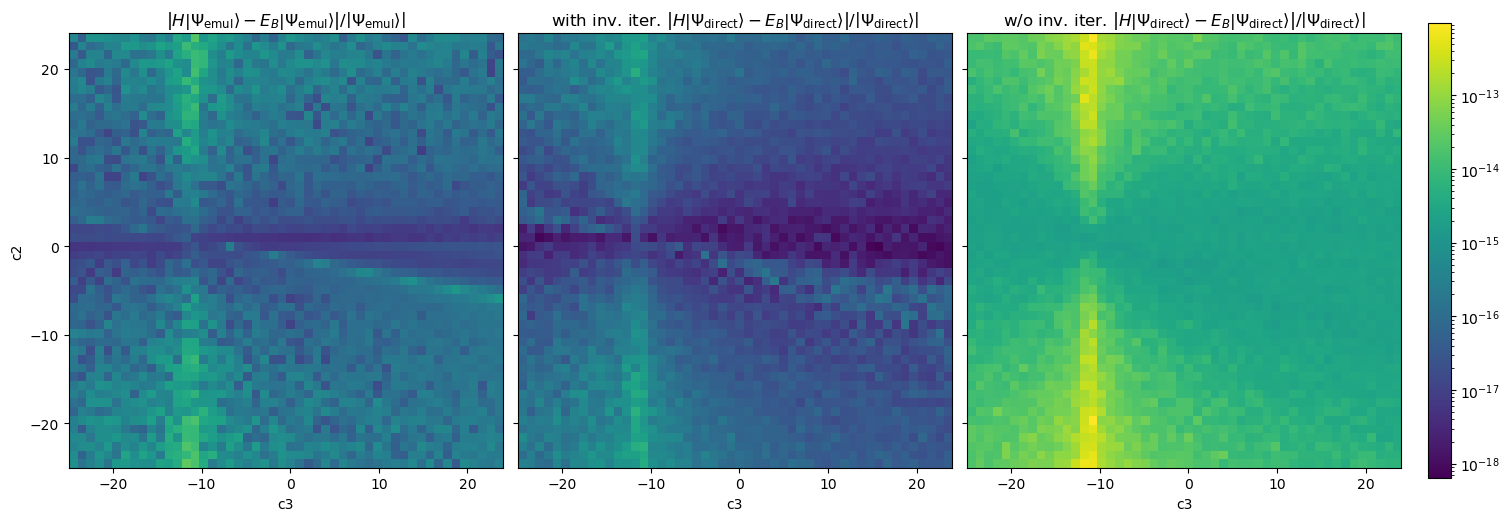

In [29]:
# Visualize the accuracy of different ways to compute Psi

vmin = min(acc_emul.min(), acc_direct_w_iter.min(), acc_direct_wo_iter.min())
vmax = max(acc_emul.max(), acc_direct_w_iter.max(), acc_direct_wo_iter.max())

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True,sharey=True,sharex=True)

im0 = axes[0].imshow(acc_emul, origin='lower', 
                     extent=[all_c3[0], all_c3[-1], all_c2[0], all_c2[-1]],
                     norm=LogNorm(vmin=vmin, vmax=vmax))
axes[0].set_xlabel('c3')
axes[0].set_ylabel('c2')
axes[0].set_title(r'$\left|{H|\Psi_\text{emul}\rangle -E_B | \Psi_\text{emul}\rangle}\right| / \left| { \Psi_\text{emul}\rangle } \right|$')

im1 = axes[1].imshow(acc_direct_w_iter, origin='lower', 
                     extent=[all_c3[0], all_c3[-1], all_c2[0], all_c2[-1]],
                     
                     norm=LogNorm(vmin=vmin, vmax=vmax))
axes[1].set_xlabel('c3')

axes[1].set_title(r'with inv. iter. $\left|{H|\Psi_\text{direct}\rangle -E_B | \Psi_\text{direct}\rangle}\right| / \left| { \Psi_\text{direct}\rangle } \right|$')

im2 = axes[2].imshow(acc_direct_wo_iter, origin='lower', 
                     extent=[all_c3[0], all_c3[-1], all_c2[0], all_c2[-1]],
                     norm=LogNorm(vmin=vmin, vmax=vmax))
axes[2].set_xlabel('c3')
axes[2].set_title(r'w/o inv. iter. $\left|{H|\Psi_\text{direct}\rangle -E_B | \Psi_\text{direct}\rangle}\right| / \left| { \Psi_\text{direct}\rangle } \right|$')

fig.colorbar(im0,ax=axes, orientation='vertical',fraction=0.018,pad=0.02)
plt.show()

From the plot above, we can see, that while we have reduced the computational cost from finding an eigenvector of a $100\times100$ matrix to finding an eigenvector of only a $2 \times 2$ matrix, the computed eigenvector satisfies the eigenvalue equation still with an accuracy of the order of machine precision!

For building the emulator, we have calculated 4 high-precision snapshots in a narrow parameter region $[-0.1, 0.1]$ and project the Schrödinger equation on a basis constructed out of the snapshots. The emulated wavefunction is accurate even far outside of the parameter region where snapshots were taken, because our emulator is exact.

## Semi-analytic expression for mean-square matter radius using the emulator
Finally we will derive a semi-analytic expression for the mean-square matter radius of the bound state.
This demonstrates exact emulation of observables which directly depend on wave function.

In [30]:
# calculate the eigenvector Psired of Hamiltonian in reduced basis
# full wavefunction is given then by B@Psired
# eigenvector of a 2x2 matrix to eigenvalue Eb is given by:
# this expression may be found by (H-Eb*1)Psired = 0
Psired      = np.array([   H_red[0,1],
                       Eb-H_red[0,0]])
# Let's inspect the dependence of alpha on c1,c2,c3
print(Psired)

[-0.818232213645501*c_1 - 0.160265102625974*c_2 - 0.000458865051112316*c_3 + 0.0109092936637554
 -0.0262412707950258*c_1 - 0.0020622294727929*c_2 - 5.77178209168864e-6*c_3 - 0.00218699889270423]


In [31]:
# transform the found basis into coordinate space
B_prime=np.zeros((len(r_points),basis_size),dtype=np.complex128)
for idx in range(basis_size):
    wf_p = B[:,idx]
    wf_r = FT_WF_to_coordinate(wf_p, momentum_grid   = p_points,
                                     coordinate_grid = r_points)
    B_prime[:,idx]=wf_r

In [32]:
B_primeT_dr_B_prime   = B_prime.T @ np.diag(r_weights)             @ B_prime
B_primeT_r2dr_B_prime = B_prime.T @ np.diag(r_points**2*r_weights) @ B_prime

In [33]:
radius_squared = 1/4*(Psired.T @ B_primeT_r2dr_B_prime @ Psired) / \
                     (Psired.T @ B_primeT_dr_B_prime   @ Psired)

In [ ]:
# fix parameter-independent part of mean-square radius denominator to be 1
N,D = sympy.simplify(radius_squared).as_numer_denom()
should_be_1    = D.subs({c1_symb:0, c2_symb:0, c3_symb:0})
radius_squared = (N/(should_be_1))/(D/(should_be_1))

In [ ]:
# Let us have a look at the semi-analytic formula for the
# mean-square radius
radius_squared.evalf(3)

(3.87e+4*c_1**2 + 1.49e+4*c_1*c_2 + 42.7*c_1*c_3 - 822.0*c_1 + 1.44e+3*c_2**2 + 8.24*c_2*c_3 - 165.0*c_2 + 0.0118*c_3**2 - 0.473*c_3 + 7.2)/(360.0*c_1**2 + 138.0*c_1*c_2 + 0.395*c_1*c_3 - 7.19*c_1 + 14.7*c_2**2 + 0.0841*c_2*c_3 - 3.72*c_2 + 0.000121*c_3**2 - 0.0107*c_3 + 1.0)

In [ ]:
# Finally let's calculate the mean-square radius for same parameters as before
rms_emul  = np.sqrt(float(
        radius_squared.subs(
            {c1_symb:test_c1, c2_symb:test_c2, c3_symb:test_c3})))
#print rms in units of fm:
print(rms_emul/fm)

1.9634030102079139


In [37]:
# compare with result obtained earlier:
print(str(round(rms_ordinary/fm,6)) +" fm - matter radius calculated directly")
print(str(round(rms_emul/fm,6)) +" fm - matter radius calculated using semi-analytic formula (exact emulator)")

1.963397 fm - matter radius calculated directly
1.963403 fm - matter radius calculated using semi-analytic formula (exact emulator)


In [38]:
# the difference is due to inaccuracy of our implementation of Fourier transform 

# check norm of coordinate-space WF to estimate expected accuracy of FT
print(1-np.sum(r_weights*u_r**2))

5.885010937345392e-06


In [39]:
# relative difference of the rms using the two different methods
# Agrees (roughly in the order of) with the accuracy of FT 
(rms_emul-rms_ordinary)/rms_ordinary

2.9425184196017354e-06

### Latex expressions for suppelemental material

In [40]:
# latex expression for c1 as function of c2 and c3 
# constrained, such that hamiltonian has Eb as eigenvalue
sympy.latex(c1_fixtoBE_symb.evalf(5))

'\\frac{- 0.54882 c_{2}^{2} + 0.94125 c_{2} + 0.081345 c_{3} + 0.52622}{- 0.54882 c_{3} - 6.2731}'

In [41]:
#
num, den = radius_squared.as_numer_denom()

monomial_exponents = [
    (2, 0, 0),  # 1:  c_1^2
    (1, 1, 0),  # 2:  c_1*c_2
    (1, 0, 1),  # 3:  c_1*c_3
    (1, 0, 0),  # 4:  c_1
    (0, 2, 0),  # 5:  c_2^2
    (0, 1, 1),  # 6:  c_2*c_3
    (0, 1, 0),  # 7:  c_2
    (0, 0, 2),  # 8:  c_3^2
    (0, 0, 1),  # 9:  c_3
    (0, 0, 0),  # 10: constant
]

def extract_coeffs(poly_expr, mono_exp_list):
    p = sympy.Poly(sympy.expand(poly_expr), c1_symb, c2_symb, c3_symb)
    coeff_dict = p.as_dict()  # keys are exponent tuples, values are exact coefficients
    return [float(coeff_dict.get(exp, 0)) for exp in mono_exp_list]

b = extract_coeffs(num, monomial_exponents)
d = extract_coeffs(den, monomial_exponents)

# Format as LaTeX table 
def fmt(val):
    return f"{val:.5g}"

b_str = " $ & $ ".join(fmt(v) for v in b)
d_str  = " $ & $ ".join(fmt(v) for v in d)

latex_table = f"$\\b_i$ & {b_str} $\\\\\n$\\d_i$  & {d_str}  $\\\\\n"

print(latex_table)

$\b_i$ & 38696 $ & $ 14904 $ & $ 42.661 $ & $ -821.8 $ & $ 1439.2 $ & $ 8.2397 $ & $ -165.14 $ & $ 0.011793 $ & $ -0.47299 $ & $ 7.1978 $\\
$\d_i$  & 360.17 $ & $ 138.17 $ & $ 0.39547 $ & $ -7.1921 $ & $ 14.669 $ & $ 0.0841 $ & $ -3.7187 $ & $ 0.00012054 $ & $ -0.010747 $ & $ 1  $\\

